In [31]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

from xgboost import XGBClassifier


In [32]:
df = pd.read_csv('FINAL_LA_FIRE_ML_DATA_MERGED.csv')

df = df.drop(columns=['date', 'STATION', 'NAME', 'fire_count'])

num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

for c in df.select_dtypes(include=['object','category']):
    df[c] = pd.factorize(df[c].astype(str))[0]


In [33]:
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

for c in df.select_dtypes(include=['object','category']):
    df[c] = pd.factorize(df[c].astype(str))[0]


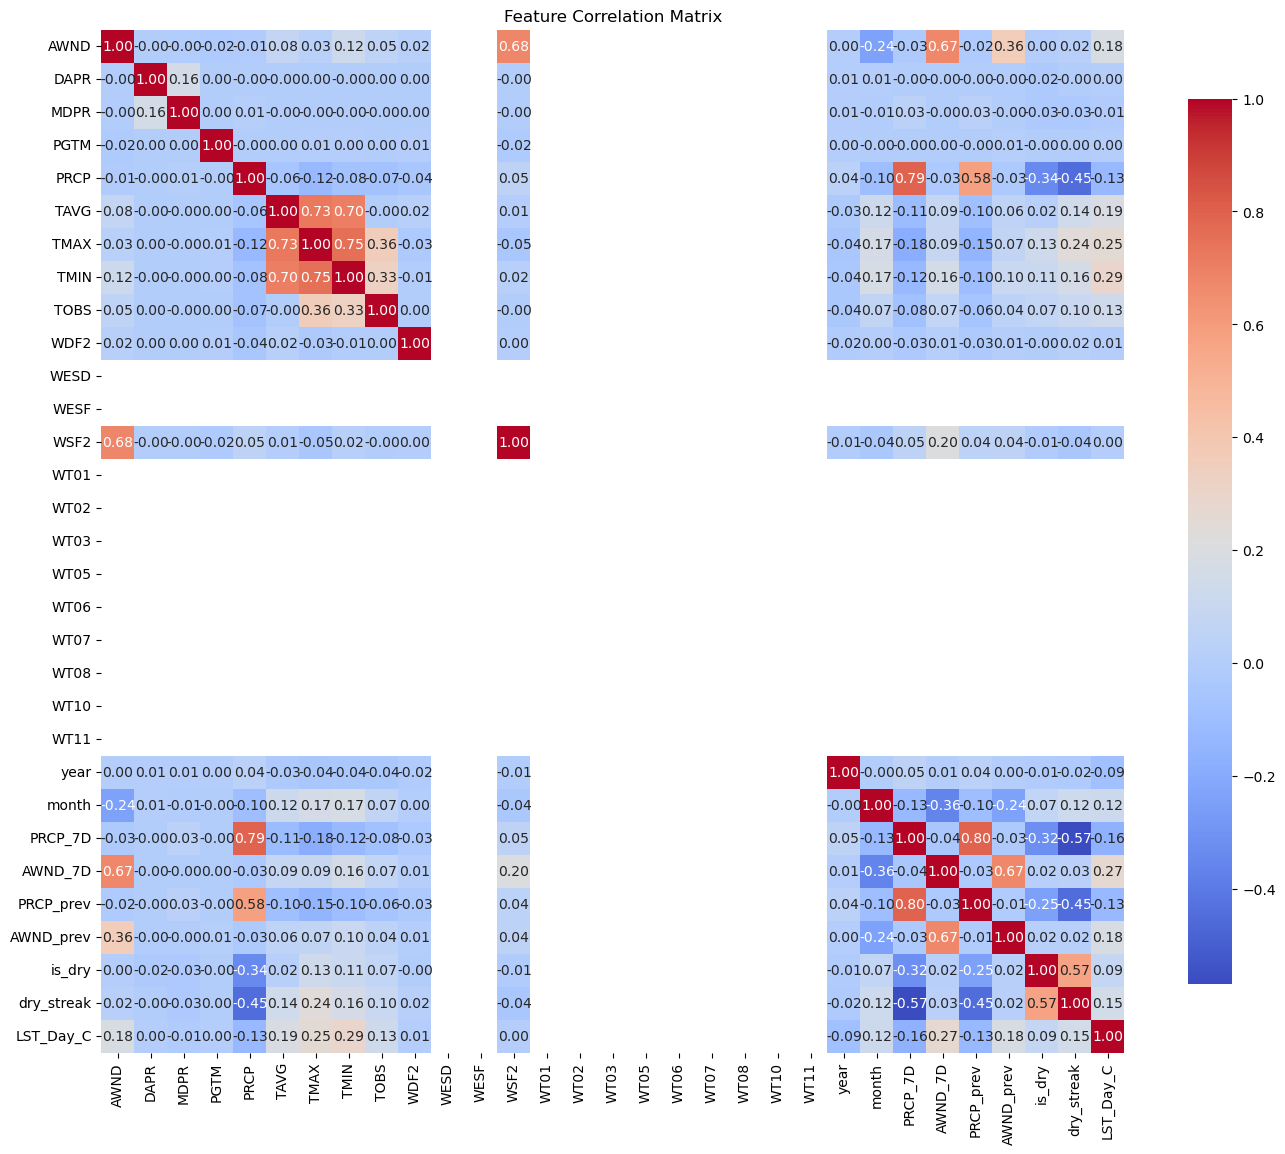

In [34]:

import seaborn as sns
import matplotlib.pyplot as plt

feature_cols = [c for c in df.columns 
                if c not in ['date','STATION','NAME','fire_count','Fire_Occurred']]

corr = df[feature_cols].corr()

plt.figure(figsize=(14,12))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()


In [35]:
TARGET = 'Fire_Occurred'
X = df.drop(TARGET, axis=1)
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)


In [36]:
# Cell 5: Upsample the minority class in TRAIN only
train_df = pd.concat([X_train, y_train.rename('tgt')], axis=1)
maj = train_df[train_df.tgt == 0]
min_ = train_df[train_df.tgt == 1]

min_up = resample(
    min_,
    replace=True,
    n_samples=len(maj),
    random_state=42
)

up = pd.concat([maj, min_up])
X_tr_res, y_tr_res = up.drop('tgt', axis=1), up['tgt']


In [37]:
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

model.fit(X_tr_res, y_tr_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

In [38]:
y_prob = model.predict_proba(X_test)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

print(f"Accuracy:       {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC:        {roc_auc_score(y_test, y_prob):.4f}\n")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy:       0.6757
ROC AUC:        0.8963

Confusion Matrix:
 [[27517 14591]
 [    5  2891]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.65      0.79     42108
           1       0.17      1.00      0.28      2896

    accuracy                           0.68     45004
   macro avg       0.58      0.83      0.54     45004
weighted avg       0.95      0.68      0.76     45004



In [39]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

param_dist = {
    'n_estimators':    [100, 200, 300, 400],
    'max_depth':       [3, 5, 7, 9],
    'learning_rate':   [0.01, 0.05, 0.1, 0.2],
    'subsample':       [0.6, 0.8, 1.0],
    'colsample_bytree':[0.6, 0.8, 1.0],
    'reg_alpha':       [0, 1, 5],
    'reg_lambda':      [1, 5, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,                 
    scoring='accuracy',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_tr_res, y_tr_res)
print("Best CV accuracy:", f"{search.best_score_:.4f}")
print("Best hyperparameters:", search.best_params_)

best_model = search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV accuracy: 0.9231
Best hyperparameters: {'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


In [40]:

y_prob = best_model.predict_proba(X_test)[:, 1]

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

import pandas as pd
predictions = pd.DataFrame({
    'Actual_Label':      y_test.values,
    'Predicted_Prob':    y_prob,
    'Predicted_Label':   y_pred
}, index=X_test.index)

display(predictions.head(20))

predictions.to_csv('fire_predictions.csv', index=True)


,Actual_Label,Predicted_Prob,Predicted_Label
127871,1,0.810513,1
186038,0,0.000064,0
196947,0,0.099232,0
121182,0,0.452340,0
118541,0,0.061023,0
41967,1,0.994411,1
50643,0,0.000010,0
42049,0,0.114901,0
13901,0,0.839812,1
169200,0,0.521156,1


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

if 'search' in globals():
    best_model = search.best_estimator_
else:
    best_model = model

probs = best_model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 101)
acc_scores = []
for t in thresholds:
    preds = (probs >= t).astype(int)
    acc_scores.append(accuracy_score(y_test, preds))

best_idx    = np.argmax(acc_scores)
best_thresh = thresholds[best_idx]
best_acc    = acc_scores[best_idx]

print(f"Optimal threshold for accuracy: {best_thresh:.2f}")
print(f"Max achievable accuracy:        {best_acc:.4f}")


In [41]:
import pandas as pd

orig = pd.read_csv('FINAL_LA_FIRE_ML_DATA_MERGED.csv')
idents = orig[['date','STATION','NAME']].reset_index(drop=True)

X_all = X.reset_index(drop=True)

final_model = search.best_estimator_ if 'search' in globals() else model
threshold   = best_thresh if 'best_thresh' in globals() else 0.5

probs  = final_model.predict_proba(X_all)[:, 1]
labels = (probs >= threshold).astype(int)

pred_table = pd.concat([idents, X_all], axis=1)
pred_table['Predicted_Prob(Fire)']  = probs
pred_table['Predicted_Label(Fire)'] = labels

pred_table.to_csv('LA_Fire_Predictions_Table.csv', index=False)
display(pred_table.head())


,date,STATION,NAME,AWND,DAPR,MDPR,PGTM,PRCP,TAVG,TMAX,...,month,PRCP_7D,AWND_7D,PRCP_prev,AWND_prev,is_dry,dry_streak,LST_Day_C,Predicted_Prob(Fire),Predicted_Label(Fire)
0,2014-12-27,NaN,NaN,4.7,4.0,0.0,1428.0,0.0,63.0,75.0,...,6.0,0.004205,4.803548,0.0,4.7,1.0,6.0,12.674622,0.071681,0
1,2014-12-28,NaN,NaN,4.7,4.0,0.0,1428.0,0.0,63.0,75.0,...,6.0,0.004205,4.803548,0.0,4.7,1.0,6.0,12.674622,0.071681,0
2,2014-12-29,NaN,NaN,4.7,4.0,0.0,1428.0,0.0,63.0,75.0,...,6.0,0.004205,4.803548,0.0,4.7,1.0,6.0,12.674622,0.071681,0
3,2014-12-30,NaN,NaN,4.7,4.0,0.0,1428.0,0.0,63.0,75.0,...,6.0,0.004205,4.803548,0.0,4.7,1.0,6.0,12.674622,0.071681,0
4,2014-12-31,NaN,NaN,4.7,4.0,0.0,1428.0,0.0,63.0,75.0,...,6.0,0.004205,4.803548,0.0,4.7,1.0,6.0,12.674622,0.071681,0


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

final_model = search.best_estimator_ if 'search' in globals() else model

imp = final_model.get_booster().get_score(importance_type='gain')
feat_imp = (
    pd.DataFrame.from_dict(imp, orient='index', columns=['gain'])
      .sort_values('gain', ascending=False)
)

plt.figure(figsize=(8,6))
feat_imp['gain'].head(15).sort_values().plot.barh()
plt.title("Top 15 Features by Gain")
plt.xlabel("Average Gain")
plt.tight_layout()
plt.show()


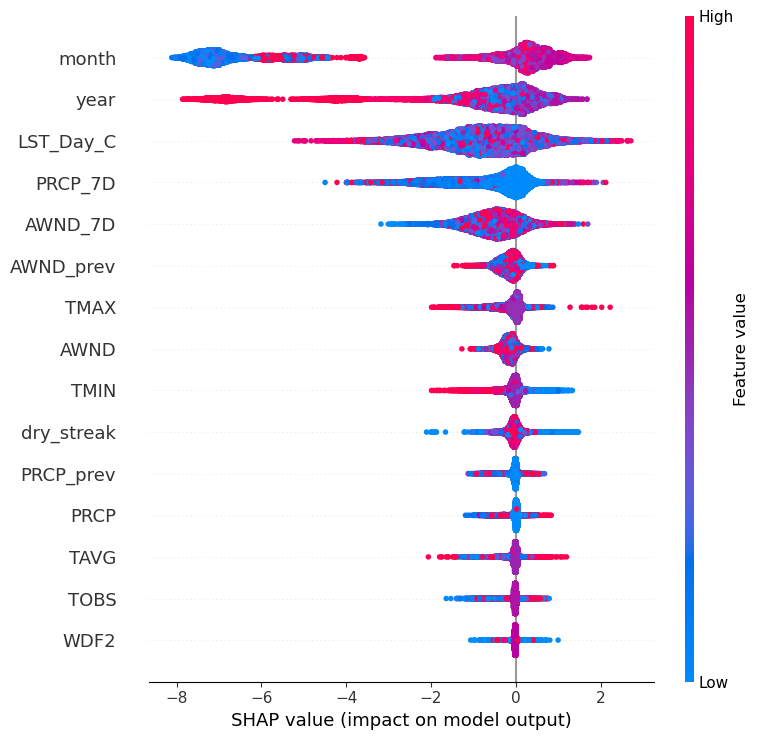

In [42]:
import shap

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values, 
    X_test, 
    plot_type="dot", 
    max_display=15
)


In [25]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.4/546.4 kB 16.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [43]:
from sklearn.inspection import plot_partial_dependence

top_feats = feat_imp.index[:3].tolist()  # pick top 3 by gain
fig, ax = plt.subplots(1, len(top_feats), figsize=(len(top_feats)*4, 4))
plot_partial_dependence(
    final_model, 
    X_test, 
    features=top_feats, 
    grid_resolution=50,
    ax=ax
)
plt.tight_layout()
plt.show()


ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (/Users/vaheedurrehman/anaconda3/lib/python3.11/site-packages/sklearn/inspection/__init__.py)

In [ ]:
from sklearn.calibration import calibration_curve

y_prob = final_model.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_prob = final_model.predict_proba(X_test)[:,1]
prec, rec, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.step(rec, prec, where='post', label=f'AP={ap:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=9, n_estimators=400, reg_alpha=5, reg_lambda=5, subsample=1.0; total time=  10.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=300, reg_alpha=1, reg_lambda=5, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=400, reg_alpha=5, reg_lambda=10, subsample=0.8; total time=   5.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=400, reg_alpha=1, reg_lambda=10, subsample=0.6; total time=  13.6s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=9, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   8.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=5, subsample=0.6; total time=   7.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=400, reg_alpha=5, reg_lambda=5, subsample=1.0; total time=   9.2s
[C

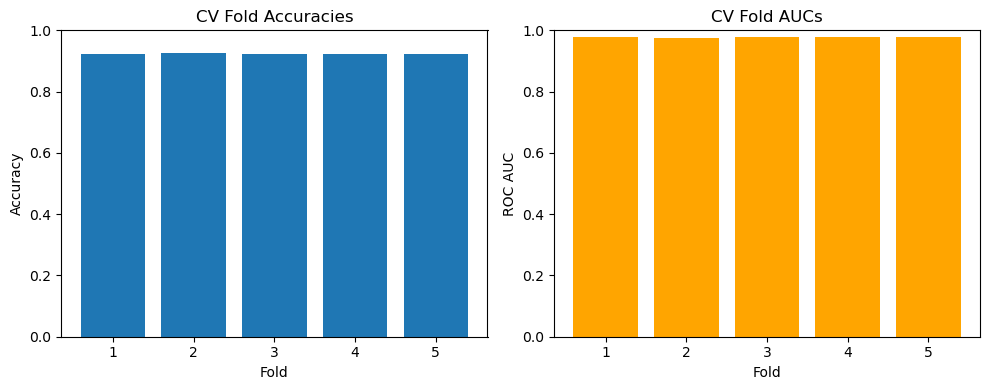

In [44]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np
import matplotlib.pyplot as plt

model_to_eval = search.best_estimator_ if 'search' in globals() else model

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    model_to_eval,
    X_tr_res, y_tr_res,
    cv=cv,
    scoring=['accuracy', 'roc_auc'],
    return_train_score=False
)
acc_folds = cv_results['test_accuracy']
auc_folds = cv_results['test_roc_auc']
folds     = np.arange(1, len(acc_folds) + 1)

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.bar(folds, acc_folds)
plt.ylim(0,1)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('CV Fold Accuracies')

plt.subplot(1, 2, 2)
plt.bar(folds, auc_folds, color='orange')
plt.ylim(0,1)
plt.xlabel('Fold')
plt.ylabel('ROC AUC')
plt.title('CV Fold AUCs')

plt.tight_layout()
plt.show()


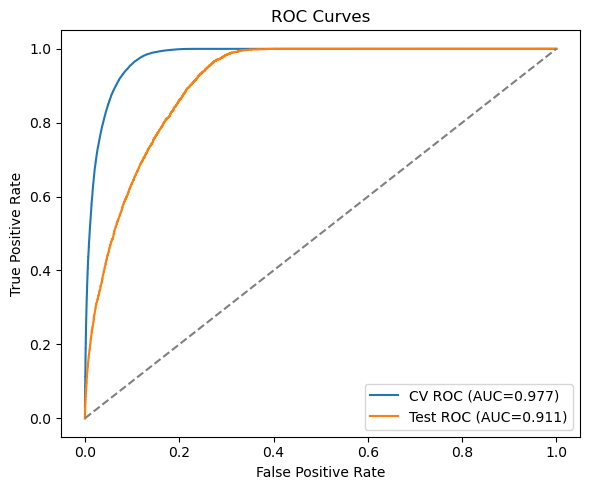

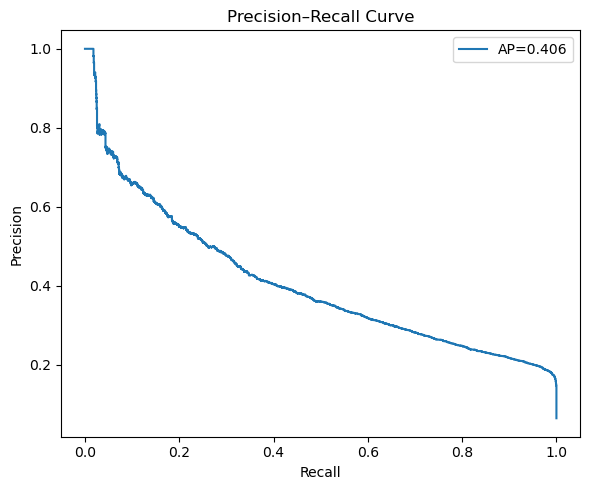

In [45]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

mdl = search.best_estimator_ if 'search' in globals() else model

from sklearn.model_selection import cross_val_predict, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_prob_cv = cross_val_predict(mdl, X_tr_res, y_tr_res, cv=cv, method='predict_proba')[:,1]
y_prob_test = mdl.predict_proba(X_test)[:,1]

fpr_cv, tpr_cv, _ = roc_curve(y_tr_res, y_prob_cv)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
auc_cv  = roc_auc_score(y_tr_res, y_prob_cv)
auc_test = roc_auc_score(y_test, y_prob_test)

plt.figure(figsize=(6,5))
plt.plot(fpr_cv, tpr_cv, label=f'CV ROC (AUC={auc_cv:.3f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC={auc_test:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.tight_layout()
plt.show()

prec_cv, rec_cv, _ = precision_recall_curve(y_tr_res, y_prob_cv)
prec_test, rec_test, _ = precision_recall_curve(y_test, y_prob_test)
ap_test = average_precision_score(y_test, y_prob_test)

plt.figure(figsize=(6,5))
plt.step(rec_test, prec_test, where='post', label=f'AP={ap_test:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()
